In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import pandas as pd

# 1. Data Preparation

In [2]:
# Define data directories and files
train_dir = './image_data_cut/training'
validation_dir = './image_data_cut/validation'
test_dir = './image_data_cut/test'

train_cryingbabies_dir = os.path.join(train_dir, 'crying_babies') 
train_notcryingbabies_dir = os.path.join(train_dir, 'not_crying_babies') 
validation_cryingbabies_dir = os.path.join(validation_dir, 'crying_babies') 
validation_notcryingbabies_dir = os.path.join(validation_dir, 'not_crying_babies')
test_cryingbabies_dir = os.path.join(test_dir, 'crying_babies')
test_notcryingbabies_dir = os.path.join(test_dir, 'not_crying_babies')

#del_file = test_cryingbabies_dir+'/.DS_Store'
#if os.path.exists(del_file):
#    os.remove(del_file)

train_cryingbabies_fnames = os.listdir(train_cryingbabies_dir)
train_notcryingbabies_fnames = os.listdir(train_notcryingbabies_dir)
validation_cryingbabies_fnames = os.listdir(validation_cryingbabies_dir)
validation_notcryingbabies_fnames = os.listdir(validation_notcryingbabies_dir)
test_cryingbabies_fnames = os.listdir(test_cryingbabies_dir)
test_notcryingbabies_fnames = os.listdir(test_notcryingbabies_dir)

print("There are ", len(train_cryingbabies_fnames), " samples of crying babies for training.")
print("There are ", len(train_notcryingbabies_fnames), " samples of not crying babies for training.")
print("There are ", len(validation_cryingbabies_fnames), " samples of crying babies for validation.")
print("There are ", len(validation_notcryingbabies_fnames), " samples of not crying babies for validation.")
print("There are ", len(test_cryingbabies_fnames), " samples of crying babies for test.")
print("There are ", len(test_notcryingbabies_fnames), " samples of not crying babies for test.")

There are  921  samples of crying babies for training.
There are  1116  samples of not crying babies for training.
There are  103  samples of crying babies for validation.
There are  124  samples of not crying babies for validation.
There are  102  samples of crying babies for test.
There are  124  samples of not crying babies for test.


In [3]:
# Data preprocessing: scale, augment, resize
seed = 1# Provide the same seed and keyword arguments to the flow_from_directory methods
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)#,
                                   #vertical_flip = True)
vali_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches using train_datagen generator
batch_size = 16
figure_size = 150
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary', 
                                                    target_size = (figure_size, figure_size),
                                                    seed=seed)     

# Flow validation images in batches using vali_datagen generator
validation_generator =  vali_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary', 
                                                          target_size = (figure_size, figure_size),
                                                          seed=seed)

# Flow test images in batches using test_datagen generator
test_generator =  test_datagen.flow_from_directory( test_dir,
                                                    batch_size  = 1,
                                                    class_mode  = 'binary', 
                                                    target_size = (figure_size, figure_size),
                                                    seed=seed,
                                                    shuffle=False)

Found 2037 images belonging to 2 classes.
Found 227 images belonging to 2 classes.
Found 226 images belonging to 2 classes.


# 2. Model Definition and Training

In [4]:
# Build model
model = tf.keras.models.Sequential([
    # The first convolution 
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(figure_size, figure_size, 3)),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN    
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dropout(0.3),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for the class 'crying baby' and 1 for the class 'not crying baby'
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer = Adam(lr=0.001), 
              loss = 'binary_crossentropy', 
              metrics = ["acc"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        3

In [5]:
train_steps = np.floor((len(train_cryingbabies_fnames)+len(train_notcryingbabies_fnames))/batch_size)
vali_steps = np.floor((len(validation_cryingbabies_fnames)+len(validation_notcryingbabies_fnames))/batch_size)
test_steps = np.floor((len(test_cryingbabies_fnames)+len(test_notcryingbabies_fnames))/1)

In [6]:
# Define callbacks for saving models and earlystopping
save_model_folder = './SavedModel_lr-1e-3_3*train/'
checkpointer = ModelCheckpoint(filepath=save_model_folder + "Model.epoch_{epoch:03d}-val_acc_{val_acc:.4f}" + ".h5", 
                               monitor='val_acc', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_acc', patience=100, verbose=1)

In [7]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = train_steps,
            epochs = 400,
            validation_steps = vali_steps,
            verbose = 2,
            callbacks = [checkpointer, earlystopper])

Epoch 1/400


W1201 10:03:52.467328 140735969207168 deprecation.py:323] From /Users/ll/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1423: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1201 10:03:52.607556 140735969207168 deprecation.py:323] From /Users/ll/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.



Epoch 00001: val_acc improved from -inf to 0.54911, saving model to ./SavedModel_lr-1e-3_3*train/Model.epoch_001-val_acc_0.5491.h5
127/127 - 39s - loss: 0.6878 - acc: 0.5680 - val_loss: 0.6778 - val_acc: 0.5491
Epoch 2/400

Epoch 00002: val_acc improved from 0.54911 to 0.69196, saving model to ./SavedModel_lr-1e-3_3*train/Model.epoch_002-val_acc_0.6920.h5
127/127 - 37s - loss: 0.6696 - acc: 0.6027 - val_loss: 0.5942 - val_acc: 0.6920
Epoch 3/400

Epoch 00003: val_acc improved from 0.69196 to 0.74554, saving model to ./SavedModel_lr-1e-3_3*train/Model.epoch_003-val_acc_0.7455.h5
127/127 - 38s - loss: 0.6322 - acc: 0.6655 - val_loss: 0.5439 - val_acc: 0.7455
Epoch 4/400

Epoch 00004: val_acc did not improve from 0.74554
127/127 - 35s - loss: 0.6145 - acc: 0.6813 - val_loss: 0.6437 - val_acc: 0.6295
Epoch 5/400

Epoch 00005: val_acc did not improve from 0.74554
127/127 - 36s - loss: 0.6082 - acc: 0.6907 - val_loss: 0.5706 - val_acc: 0.7143
Epoch 6/400

Epoch 00006: val_acc did not improv

Epoch 53/400

Epoch 00053: val_acc did not improve from 0.85268
127/127 - 36s - loss: 0.2318 - acc: 0.9000 - val_loss: 0.5530 - val_acc: 0.8170
Epoch 54/400

Epoch 00054: val_acc did not improve from 0.85268
127/127 - 36s - loss: 0.2494 - acc: 0.8898 - val_loss: 0.5720 - val_acc: 0.8036
Epoch 55/400

Epoch 00055: val_acc did not improve from 0.85268
127/127 - 35s - loss: 0.2446 - acc: 0.8887 - val_loss: 0.4883 - val_acc: 0.8393
Epoch 56/400

Epoch 00056: val_acc did not improve from 0.85268
127/127 - 35s - loss: 0.2554 - acc: 0.8886 - val_loss: 0.4755 - val_acc: 0.8348
Epoch 57/400

Epoch 00057: val_acc did not improve from 0.85268
127/127 - 36s - loss: 0.2114 - acc: 0.9119 - val_loss: 0.4719 - val_acc: 0.8304
Epoch 58/400

Epoch 00058: val_acc did not improve from 0.85268
127/127 - 36s - loss: 0.2039 - acc: 0.9183 - val_loss: 0.5135 - val_acc: 0.8259
Epoch 59/400

Epoch 00059: val_acc did not improve from 0.85268
127/127 - 36s - loss: 0.2250 - acc: 0.9030 - val_loss: 0.5598 - val_acc:

Epoch 110/400

Epoch 00110: val_acc did not improve from 0.85714
127/127 - 36s - loss: 0.1141 - acc: 0.9552 - val_loss: 0.8060 - val_acc: 0.8482
Epoch 111/400

Epoch 00111: val_acc improved from 0.85714 to 0.86161, saving model to ./SavedModel_lr-1e-3_3*train/Model.epoch_111-val_acc_0.8616.h5
127/127 - 37s - loss: 0.1344 - acc: 0.9520 - val_loss: 0.7717 - val_acc: 0.8616
Epoch 112/400

Epoch 00112: val_acc did not improve from 0.86161
127/127 - 36s - loss: 0.1075 - acc: 0.9594 - val_loss: 0.7802 - val_acc: 0.8482
Epoch 113/400

Epoch 00113: val_acc did not improve from 0.86161
127/127 - 36s - loss: 0.1001 - acc: 0.9644 - val_loss: 0.8382 - val_acc: 0.8348
Epoch 114/400

Epoch 00114: val_acc did not improve from 0.86161
127/127 - 36s - loss: 0.1165 - acc: 0.9565 - val_loss: 0.9410 - val_acc: 0.8304
Epoch 115/400

Epoch 00115: val_acc did not improve from 0.86161
127/127 - 36s - loss: 0.1006 - acc: 0.9540 - val_loss: 1.0256 - val_acc: 0.8170
Epoch 116/400

Epoch 00116: val_acc did not im

Epoch 166/400

Epoch 00166: val_acc did not improve from 0.87946
127/127 - 36s - loss: 0.0542 - acc: 0.9796 - val_loss: 0.9876 - val_acc: 0.8214
Epoch 167/400

Epoch 00167: val_acc did not improve from 0.87946
127/127 - 36s - loss: 0.0570 - acc: 0.9798 - val_loss: 0.9321 - val_acc: 0.8438
Epoch 168/400

Epoch 00168: val_acc did not improve from 0.87946
127/127 - 36s - loss: 0.0860 - acc: 0.9673 - val_loss: 0.6604 - val_acc: 0.8661
Epoch 169/400

Epoch 00169: val_acc did not improve from 0.87946
127/127 - 35s - loss: 0.0867 - acc: 0.9657 - val_loss: 0.8260 - val_acc: 0.8571
Epoch 170/400

Epoch 00170: val_acc did not improve from 0.87946
127/127 - 36s - loss: 0.1118 - acc: 0.9540 - val_loss: 1.5453 - val_acc: 0.7500
Epoch 171/400

Epoch 00171: val_acc did not improve from 0.87946
127/127 - 36s - loss: 0.1135 - acc: 0.9579 - val_loss: 0.9106 - val_acc: 0.8571
Epoch 172/400

Epoch 00172: val_acc did not improve from 0.87946
127/127 - 36s - loss: 0.0752 - acc: 0.9718 - val_loss: 0.8105 - v

In [8]:
# Save the training history
import pickle 
with open(save_model_folder+'trainHistory', 'wb') as pickle_file:
        pickle.dump(history.history, pickle_file)
#with open('./SavedModel_lr-1e-4/trainHistory', 'rb') as pickle_file:
#    history_load = pickle.load(pickle_file)

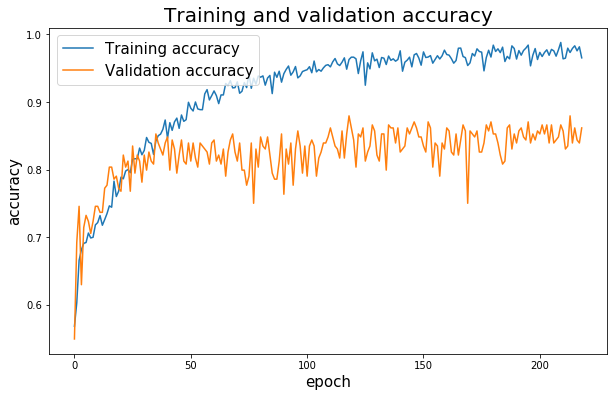

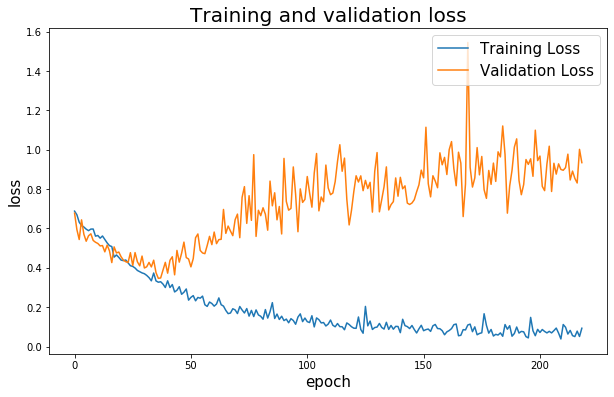

In [9]:
# Summarize history for accuracy
plt.figure(figsize=[10,6])
plt.plot(history.history['acc'], label='Training accuracy')
plt.plot(history.history['val_acc'], label='Validation accuracy')
plt.title('Training and validation accuracy', fontsize = 20)
plt.ylabel('accuracy', fontsize = 15)
plt.xlabel('epoch', fontsize = 15)
plt.legend(loc='upper left', fontsize = 15)
plt.show()

# Summarize history for loss
plt.figure(figsize=[10,6])
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and validation loss', fontsize = 20)
plt.ylabel('loss', fontsize = 15)
plt.xlabel('epoch', fontsize = 15)
plt.legend(loc='upper right', fontsize = 15)
plt.show()

# 3. Model Evaluation

In [10]:
# Load and evaluate the best model obtained
best_model_path = './SavedModel_lr-1e-3_3*train/Model.epoch_119-val_acc_0.8795.h5'
best_model = tf.keras.models.load_model(best_model_path)
evaluation = best_model.evaluate_generator(
                    test_generator,  
                    steps = test_steps,
                    verbose=1)
print("The accuracy of the best model is: {:5.2f}%".format(100*evaluation[1]))

226/226 [==============================] - 2s 9ms/step - loss: 0.9892 - acc: 0.8230
The accuracy of the best model is: 82.30%


In [11]:
# Predict by using the best model obtained
actual_labels = test_generator.classes
predictions = best_model.predict_generator(test_generator, test_steps, verbose=1)
predicted_labels = (predictions > 0.5)
predicted_labels = np.hstack(predicted_labels.astype(np.int32))

226/226 [==============================] - 3s 11ms/step


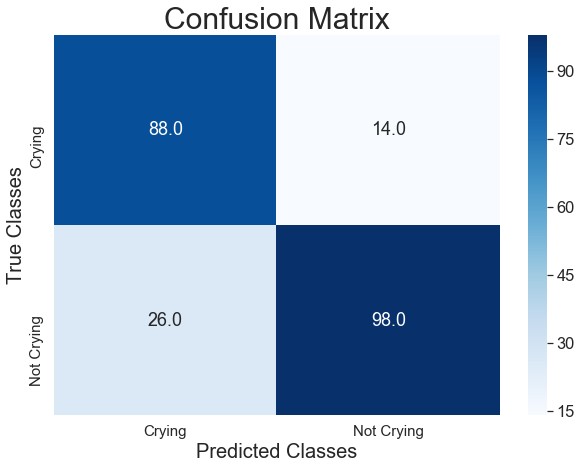

In [12]:
# Show confusion matrix
labels=["Crying", "Not Crying"]
confusion = confusion_matrix(actual_labels, predicted_labels)
sns.set(font_scale=1.5)    
plt.figure(figsize=(10,7))
sns.heatmap(confusion, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix", fontsize = 30)
plt.xlabel('Predicted Classes', fontsize = 20)
plt.ylabel('True Classes', fontsize = 20)
plt.tick_params(labelsize = 15)
plt.show()

Text(0.5, 1, 'Classification Report')

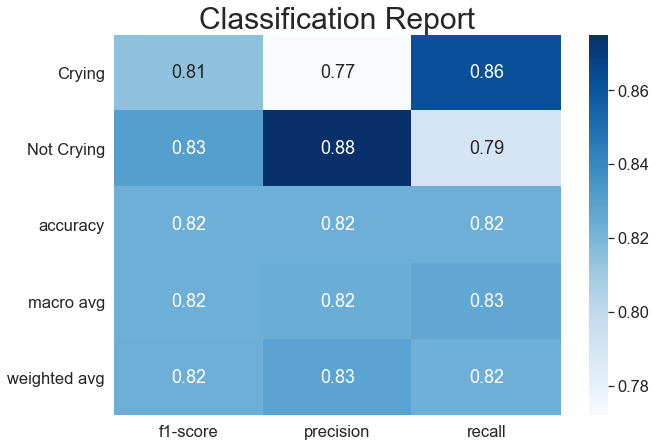

In [13]:
# Show classification report
plt.figure(figsize=(10,7))
class_report = classification_report(actual_labels, predicted_labels, target_names=labels, output_dict=True)# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, cmap = "Blues", annot=True)
plt.title("Classification Report", fontsize = 30)

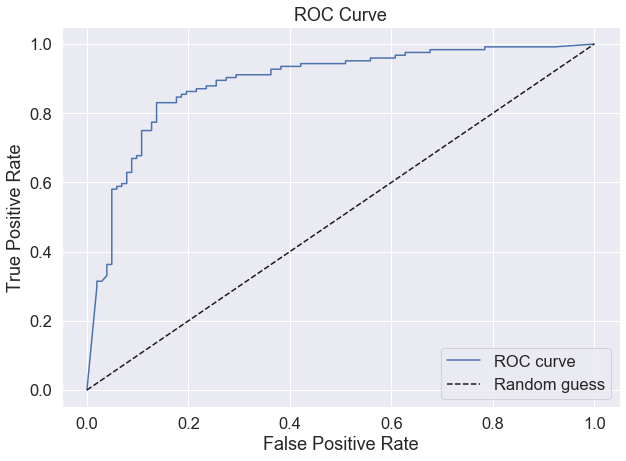

In [14]:
# Show roc curve and auc score
plt.figure(figsize=(10,7))
fpr, tpr, thresholds = roc_curve(actual_labels, predictions)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

In [15]:
print("Auc Score is: ", roc_auc_score(actual_labels, predictions))

Auc Score is:  0.8889943074003794


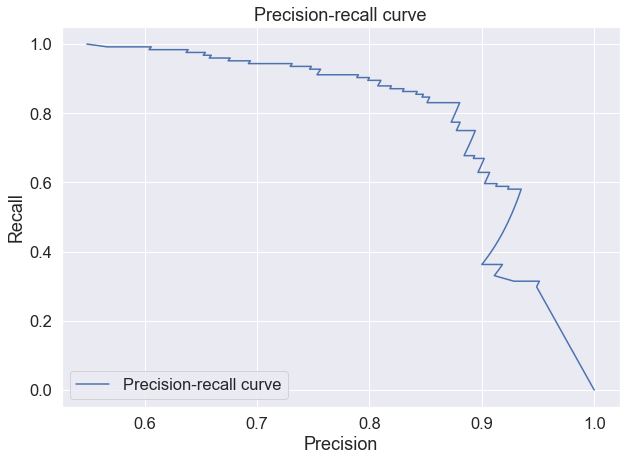

In [16]:
# Show precision-recall curve and average precision score
plt.figure(figsize=(10,7))
precision, recall, thresholds = precision_recall_curve(actual_labels, predictions)
plt.plot(precision, recall, label='Precision-recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-recall curve')
plt.legend(loc="lower left")

In [17]:
print("Average Precision Score is: {:5.2f}%".format(100*average_precision_score(actual_labels, predictions)))

Average Precision Score is: 89.29%
